In [78]:
%matplotlib inline
from __future__ import print_function
from pycocotools.coco import COCO
import os, sys, zipfile
import urllib.request
import shutil
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
from collections import defaultdict
import random
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd

In [3]:
# Record package versions for reproducibility
print("os: %s" % os.name)
print("sys: %s" % sys.version)
print("numpy: %s, %s" % (np.__version__, np.__file__))

os: nt
sys: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
numpy: 1.25.2, C:\Users\gagra\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\__init__.py


In [25]:
# Setup data paths
dataDir = 'D:\MSDA\Sem 2\GWAR\Project\cocoapi'
dataType = 'val2017'
annDir = '{}/annotations'.format(dataDir)
annZipFile = '{}/annotations_train{}.zip'.format(dataDir, dataType)
annFile = '{}/instances_{}.json'.format(annDir, dataType)
annURL = 'http://images.cocodataset.org/annotations/annotations_train{}.zip'.format(dataType)
print (annDir)
print (annFile)
print (annZipFile)
print (annURL)

D:\MSDA\Sem 2\GWAR\Project\cocoapi/annotations
D:\MSDA\Sem 2\GWAR\Project\cocoapi/annotations/instances_val2017.json
D:\MSDA\Sem 2\GWAR\Project\cocoapi/annotations_trainval2017.zip
http://images.cocodataset.org/annotations/annotations_trainval2017.zip


In [26]:
# Download data if not available locally
if not os.path.exists(annDir):
    os.makedirs(annDir)
if not os.path.exists(annFile):
    if not os.path.exists(annZipFile):
        print ("Downloading zipped annotations to " + annZipFile + " ...")
        with urllib.request.urlopen(annURL) as resp, open(annZipFile, 'wb') as out:
            shutil.copyfileobj(resp, out)
        print ("... done downloading.")
    print ("Unzipping " + annZipFile)
    with zipfile.ZipFile(annZipFile,"r") as zip_ref:
        zip_ref.extractall(dataDir)
    print ("... done unzipping")
print ("Will use annotations in " + annFile)

Will use annotations in D:\MSDA\Sem 2\GWAR\Project\cocoapi/annotations/instances_val2017.json


In [27]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

instances_annFile="D:\MSDA\Sem 2\GWAR\Project\cocoapi/annotations/instances_train2017.json"
coco = COCO(instances_annFile)
captions_annFile="D:\MSDA\Sem 2\GWAR\Project\cocoapi/annotations/instances_train2017.json"
coco_caps = COCO(captions_annFile)
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
loading annotations into memory...
Done (t=13.11s)
creating index...
index created!
loading annotations into memory...
Done (t=11.89s)
creating index...
index created!


In [28]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

print('Total categories', len(cats)) 
nms=[cat['name'] for cat in cats]
print()
print('COCO categories: \n{}\n'.format(','.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(','.join(nms)))

Total categories 80

COCO categories: 
person,bicycle,car,motorcycle,airplane,bus,train,truck,boat,traffic light,fire hydrant,stop sign,parking meter,bench,bird,cat,dog,horse,sheep,cow,elephant,bear,zebra,giraffe,backpack,umbrella,handbag,tie,suitcase,frisbee,skis,snowboard,sports ball,kite,baseball bat,baseball glove,skateboard,surfboard,tennis racket,bottle,wine glass,cup,fork,knife,spoon,bowl,banana,apple,sandwich,orange,broccoli,carrot,hot dog,pizza,donut,cake,chair,couch,potted plant,bed,dining table,toilet,tv,laptop,mouse,remote,keyboard,cell phone,microwave,oven,toaster,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush

COCO supercategories: 
food,sports,animal,vehicle,electronic,appliance,person,accessory,furniture,indoor,outdoor,kitchen


In [37]:
# Get all category ids and their corresponding names
categories = coco.loadCats(coco.getCatIds())
category_names = defaultdict(list)

for category in categories:
    category_names[category['name']].append(category['id'])

# Check for duplicate names
duplicate_category_names = {name: ids for name, ids in category_names.items() if len(ids) > 1}
print(f"Duplicate Category Names: {duplicate_category_names}")

Duplicate Category Names: {}


In [34]:
num_images = len(coco.getImgIds())

incomplete_annotation_img_ids = []

for img_id in coco.getImgIds():
    ann_ids = coco.getAnnIds(imgIds=[img_id])
    annotations = coco.loadAnns(ann_ids)
    if not annotations:  # or use any other condition to determine incompleteness
        incomplete_annotation_img_ids.append(img_id)

print('Total images', num_images)
print('Missing or incomplete annotations ', len(incomplete_annotation_img_ids))
print('Total annotations after cleaning ', num_images-len(incomplete_annotation_img_ids))

percent_missing = len(incomplete_annotation_img_ids)/num_images * 100

print("percentage of missing annotations {}%".format(round(percent_missing,3)))

Total images 118287
Missing or incomplete annotations  1021
Total annotations after cleaning  117266
percentage of missing annotations 0.863%


In [30]:
# Explore some statistics about annotations
num_annotations = len(coco.anns)
print("Number of annotations in the dataset:", num_annotations)

Number of annotations in the dataset: 860001


In [32]:
images = coco.loadImgs(coco.getImgIds())

# Count occurrences of each image URL or filename
image_urls = [img['coco_url'] for img in images]  # Use 'file_name' if URLs are not available
duplicate_urls = set(url for url in image_urls if image_urls.count(url) > 1)

len(duplicate_urls)

0

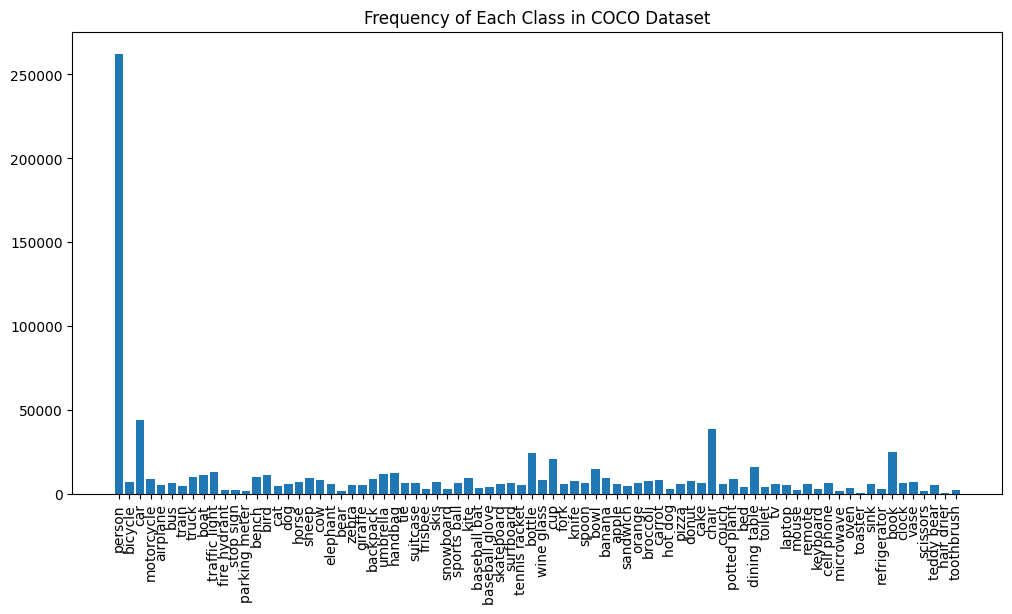

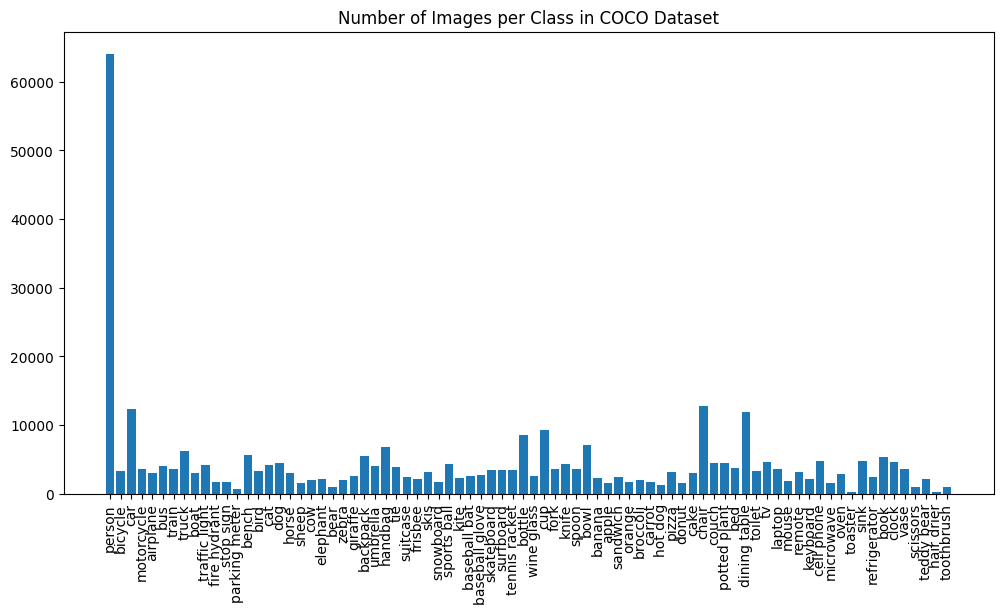

In [33]:
catIds = coco.getCatIds()
categories = coco.loadCats(catIds)
category_names = [cat['name'] for cat in categories]

# Count instances per category
category_counts = {cat: len(coco.getAnnIds(catIds=coco.getCatIds(catNms=[cat]))) for cat in category_names}

# Count images per category
images_per_category = {cat: len(coco.getImgIds(catIds=coco.getCatIds(catNms=[cat]))) for cat in category_names}

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(range(len(category_counts)), list(category_counts.values()), align='center')
plt.xticks(range(len(category_counts)), list(category_counts.keys()), rotation='vertical')
plt.title('Frequency of Each Class in COCO Dataset')
plt.show()

# Plotting images per category
plt.figure(figsize=(12, 6))
plt.bar(range(len(images_per_category)), list(images_per_category.values()), align='center')
plt.xticks(range(len(images_per_category)), list(images_per_category.keys()), rotation='vertical')
plt.title('Number of Images per Class in COCO Dataset')
plt.show()

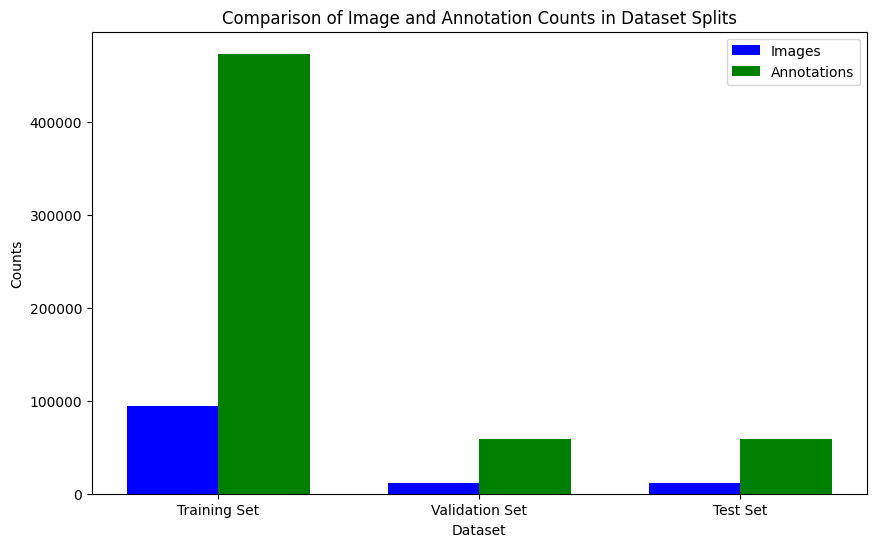

In [38]:
image_counts = [94630, 11829, 11829]
annotation_counts = [473148, 59144, 59144]
labels = ['Training Set', 'Validation Set', 'Test Set']

# Setting the positions and width for the bars
pos = np.arange(len(labels))
width = 0.35

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(pos - width/2, image_counts, width, label='Images', color='blue')
bar2 = ax.bar(pos + width/2, annotation_counts, width, label='Annotations', color='green')

# Adding labels and title
ax.set_xlabel('Dataset')
ax.set_ylabel('Counts')
ax.set_title('Comparison of Image and Annotation Counts in Dataset Splits')
ax.set_xticks(pos)
ax.set_xticklabels(labels)
ax.legend()

# Showing the plot
plt.show()

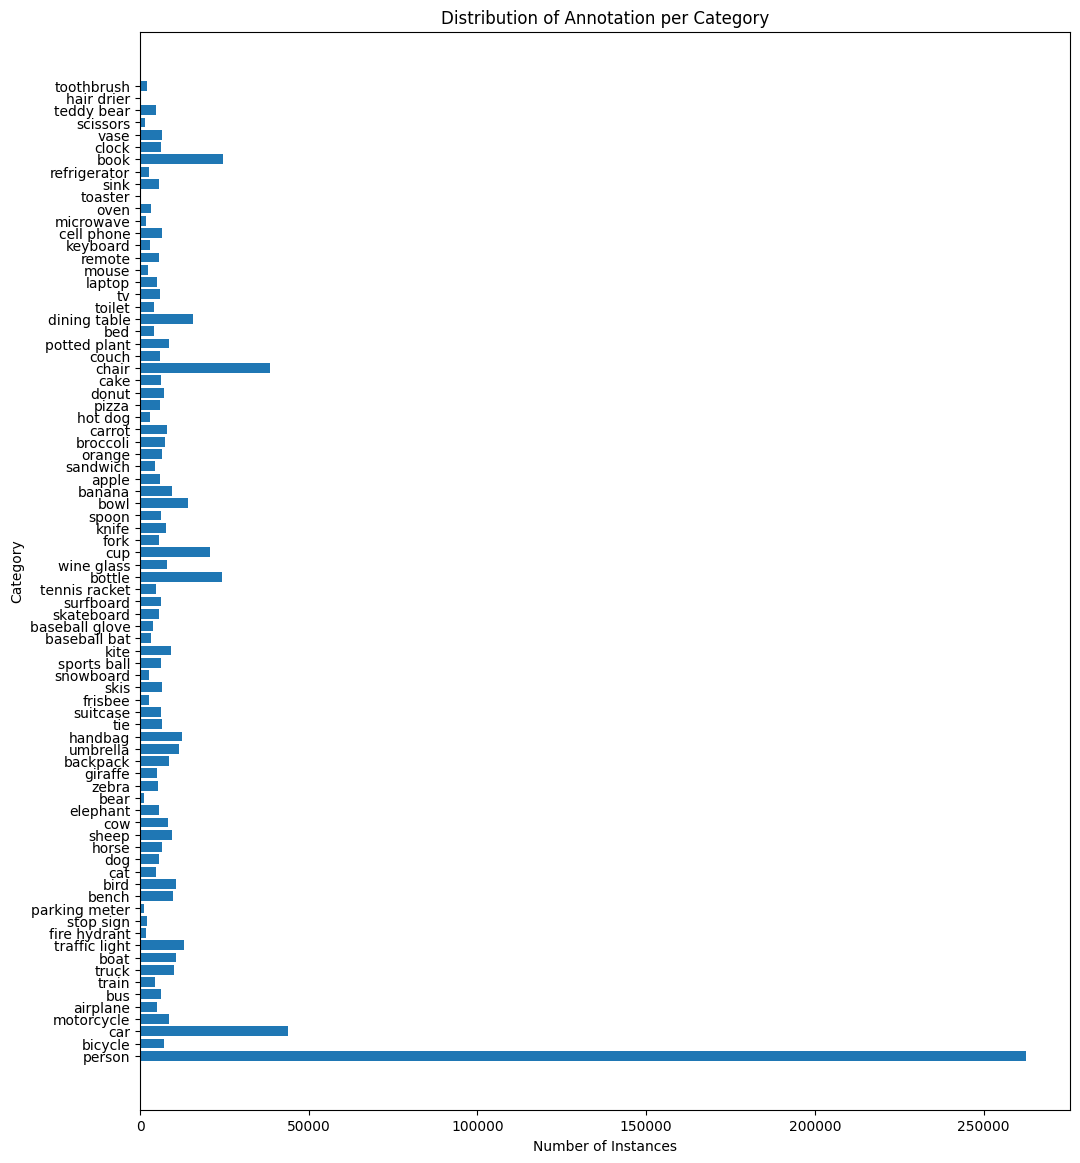

In [51]:
# Get category labels
catIds = coco.getCatIds()
cats = coco.loadCats(catIds)
cat_names = [cat['name'] for cat in cats]

# Count number of instances per category
cat_counts = [len(coco.getAnnIds(catIds=catId)) for catId in catIds]

# Plot
plt.figure(figsize=(12, 14))
plt.barh(cat_names, cat_counts)
plt.xlabel('Number of Instances')
plt.ylabel('Category')
plt.title('Distribution of Annotation per Category')
plt.show()

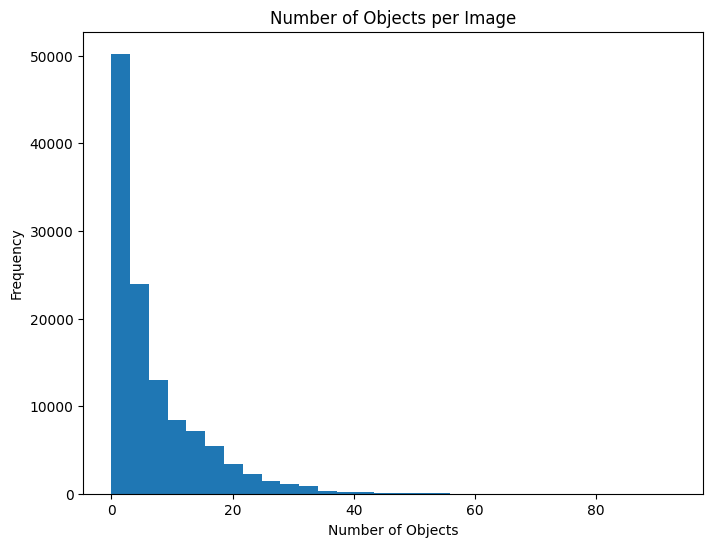

In [58]:
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds)

num_objs_per_img = [len(coco.getAnnIds(imgIds=img['id'])) for img in imgs]

# Plot
plt.figure(figsize=(8, 6))
plt.hist(num_objs_per_img, bins=30)
plt.title('Number of Objects per Image')
plt.xlabel('Number of Objects')
plt.ylabel('Frequency')
plt.show()

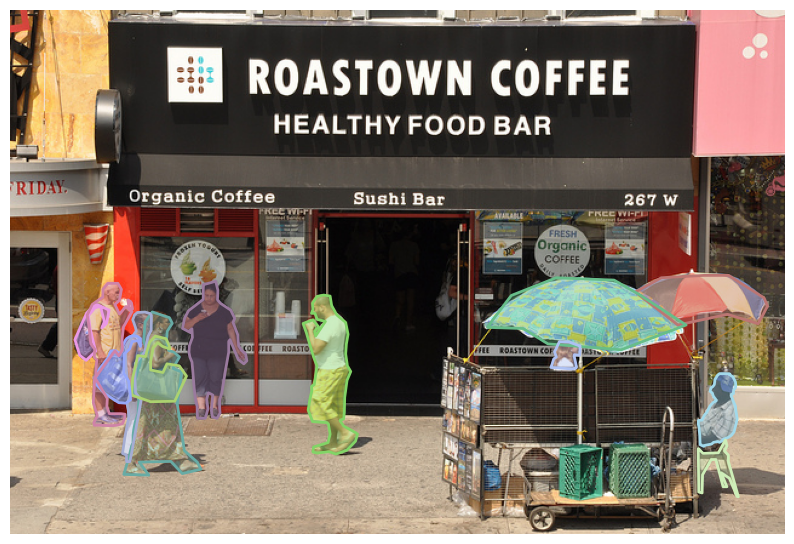

In [62]:
# Load and display image and annotations
def show_image_with_annotations(image_id):
    img = coco.loadImgs(image_id)[0]
    annIds = coco.getAnnIds(imgIds=img['id'])
    anns = coco.loadAnns(annIds)

    # Load and display image
    I = io.imread(img['coco_url'])
    plt.imshow(I); plt.axis('off')

    # Display annotations
    coco.showAnns(anns)

# Select a random image
random_img_id = random.choice(imgIds)
plt.figure(figsize=(10, 8))
show_image_with_annotations(random_img_id)

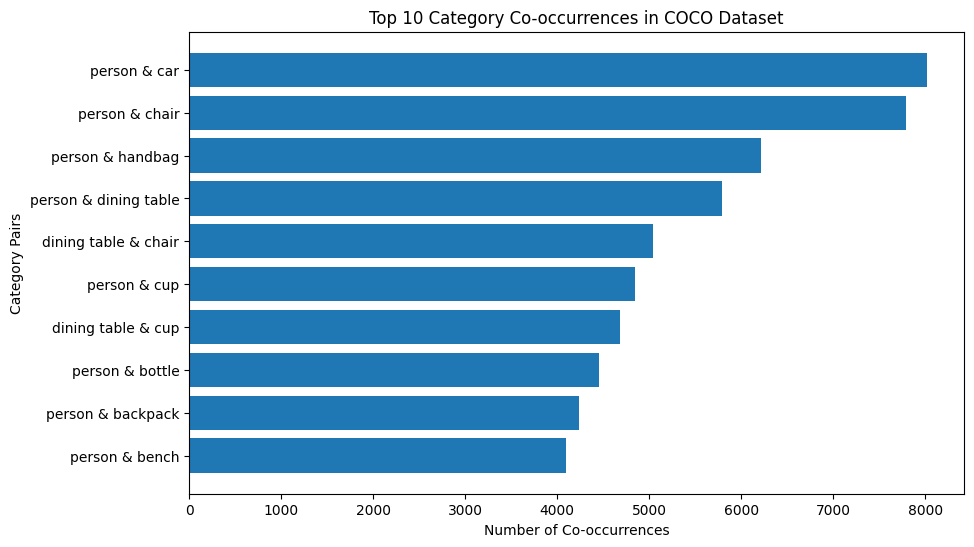

In [63]:
catIds = coco.getCatIds()
cats = coco.loadCats(catIds)
cat_names = {cat['id']: cat['name'] for cat in cats}

# Prepare for co-occurrence analysis
co_occurrence = collections.defaultdict(int)
imgIds = coco.getImgIds()

# Calculate co-occurrence
for imgId in imgIds:
    annIds = coco.getAnnIds(imgIds=imgId)
    anns = coco.loadAnns(annIds)
    categories = [ann['category_id'] for ann in anns]
    unique_categories = set(categories)
    for combo in combinations(unique_categories, 2):
        co_occurrence[combo] += 1

# Sort by frequency
sorted_co_occurrences = sorted(co_occurrence.items(), key=lambda x: x[1], reverse=True)

# Select top N co-occurrences to display
top_n = 10
top_co_occurrences = sorted_co_occurrences[:top_n]

# Prepare data for plotting
labels = [f"{cat_names[pair[0]]} & {cat_names[pair[1]]}" for pair, _ in top_co_occurrences]
counts = [count for _, count in top_co_occurrences]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(labels, counts)
plt.xlabel('Number of Co-occurrences')
plt.ylabel('Category Pairs')
plt.title(f'Top {top_n} Category Co-occurrences in COCO Dataset')
plt.gca().invert_yaxis()  # invert y-axis for better readability
plt.show()

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


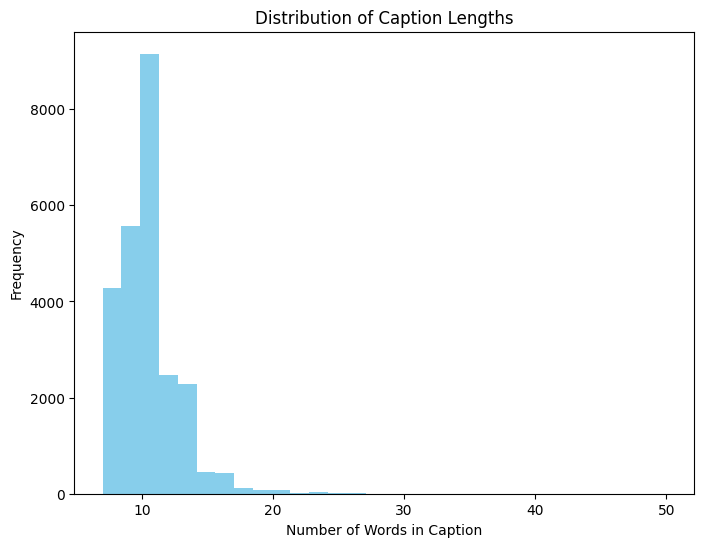

In [74]:
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

captions = []
caption_lengths = []
for ann in coco_caps.anns.values():
    caption = ann['caption']
    captions.append(caption)
    caption_lengths.append(len(caption.split()))

# Plotting caption length distribution
plt.figure(figsize=(8, 6))
plt.hist(caption_lengths, bins=30, color='skyblue')
plt.title('Distribution of Caption Lengths')
plt.xlabel('Number of Words in Caption')
plt.ylabel('Frequency')
plt.show()

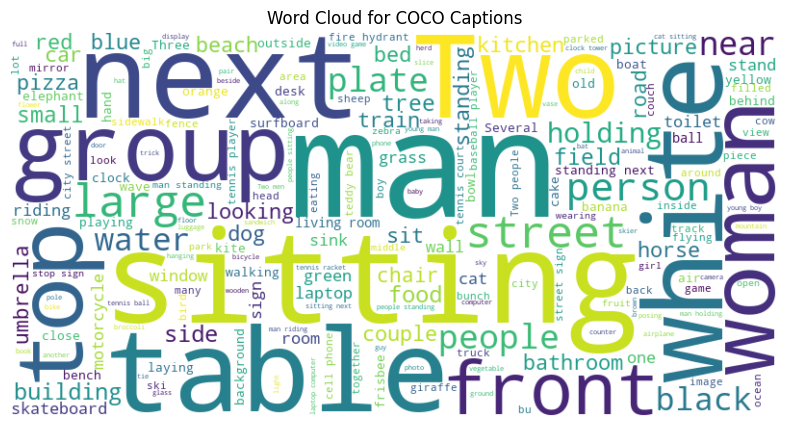

In [75]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(captions))

# Plotting word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for COCO Captions')
plt.show()